##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/anomaly_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>This notebook requires paid tier rate limits to run properly.<br>  
(cf. <a href="https://ai.google.dev/pricing#veo2"><font color='#217bfe'>pricing</font></a> for more details).</font></h3>
    </td>
  </tr>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and detect outliers outside a particular radius of the central point of each categorical cluster.

For more information on getting started with embeddings generated from the Gemini API, check out the [Get Started](../quickstarts/Get_started.ipynb).

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.11+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [2]:
!pip install -U -q google-genai

In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google import genai
from google.genai import types

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

### Grab an API Key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GEMINI_API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GEMINI_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.Client(api_key=...)`

In [ ]:
# Or use `os.getenv('GEMINI_API_KEY')` to fetch an environment variable.
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

client = genai.Client(api_key=GEMINI_API_KEY)

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

In [6]:
for m in client.models.list():
  if 'embedContent' in m.supported_actions:
    print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp
models/gemini-embedding-001


### Select the model to be used

In [20]:
MODEL_ID = "gemini-embedding-001" # @param ["gemini-embedding-001", "text-embedding-004"] {"allow-input":true, isTemplate: true}

## Prepare the dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [7]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [8]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [9]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [55]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [56]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

/tmp/ipykernel_100019/406673449.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,Privacy & Anonymity on the Internet FAQ \nSup...,11,sci.crypt
1,1651,The source of that announcement\nOrganization...,11,sci.crypt
2,1652,"Would ""clipper"" make a good cover for other e...",11,sci.crypt
3,1653,What the clipper nay-sayers sound like to me....,11,sci.crypt
4,1654,alt.security.pgp\nNntp-Posting-Host: bootes.c...,11,sci.crypt
...,...,...,...,...
595,2245,"Re: Terraforming Venus: can it be done ""cheap...",14,sci.space
596,2246,Re: *Doppelganger* \nArticle-I.D.: mojo.1qkn6...,14,sci.space
597,2247,Re: What if the USSR had reached the Moon fir...,14,sci.space
598,2248,Re: DC-X Rollout Report\nArticle-I.D.: topaz....,14,sci.space


In [57]:
df_train['Class Name'].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

## Generate the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

The Gemini embedding model supports several task types, each tailored for a specific goal. Here’s a general overview of the available types and their applications:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

def make_embed_text_fn(model):

  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    result = client.models.embed_content(model=model,
                                            contents=text,
                                            config=types.EmbedContentConfig(
                                                task_type="CLUSTERING"))
    return np.array(result.embeddings[0].values)

  return embed_fn

def create_embeddings(df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(MODEL_ID))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

100%|██████████| 600/600 [06:11<00:00,  1.62it/s]


## Dimensionality reduction

The dimension of the document embedding vector is 3072. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [67]:
len(df_train['Embeddings'][0])

3072

In [68]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 3072)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [73]:
tsne = TSNE(random_state=0)
tsne_results = tsne.fit_transform(X)

In [71]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,39.326805,-15.291752,sci.crypt
1,25.044193,-2.996266,sci.crypt
2,30.786301,-6.652494,sci.crypt
3,26.256178,-9.720546,sci.crypt
4,41.185246,-8.945529,sci.crypt
...,...,...,...
595,-25.796329,8.991899,sci.space
596,-20.514021,0.129148,sci.space
597,-22.480268,6.861408,sci.space
598,-23.748753,14.050385,sci.space


Text(0, 0.5, 'TSNE2')

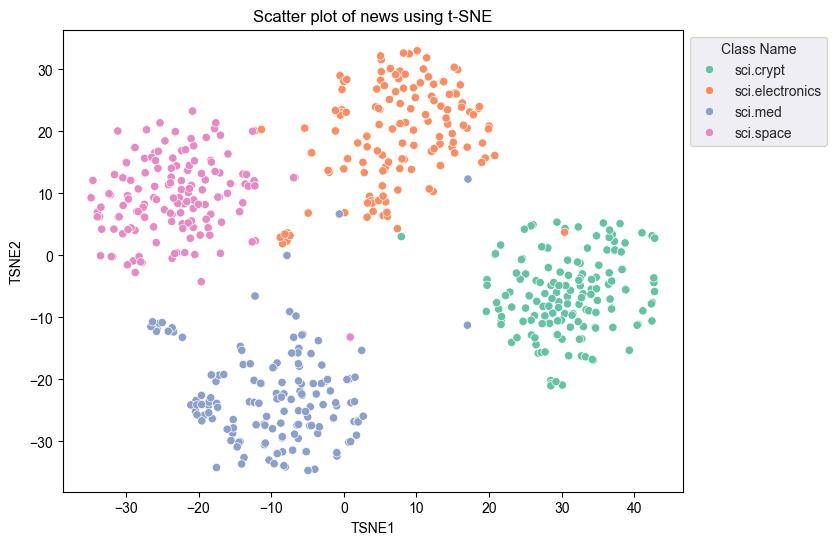

In [74]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [75]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,31.146711,-6.366441
sci.electronics,7.322525,19.477852
sci.med,-9.485087,-22.437294
sci.space,-23.256557,9.471162


In [76]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [77]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

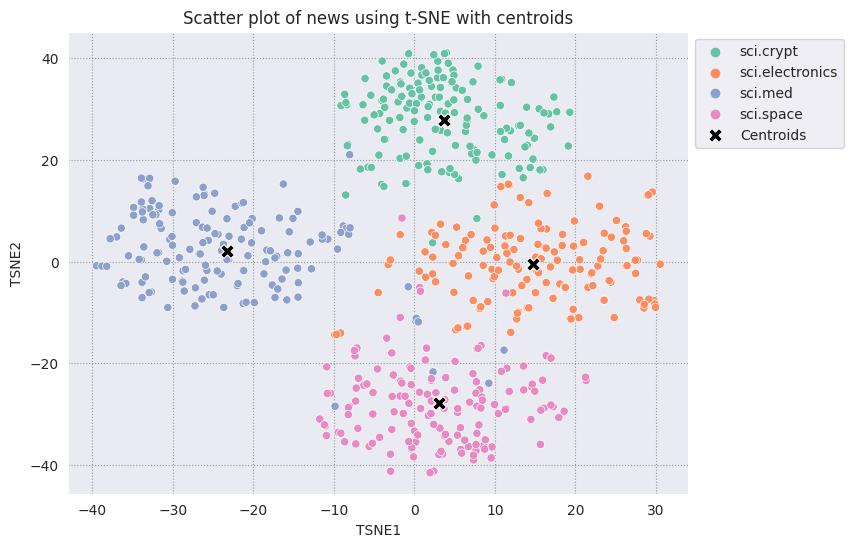

In [ ]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [78]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [79]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

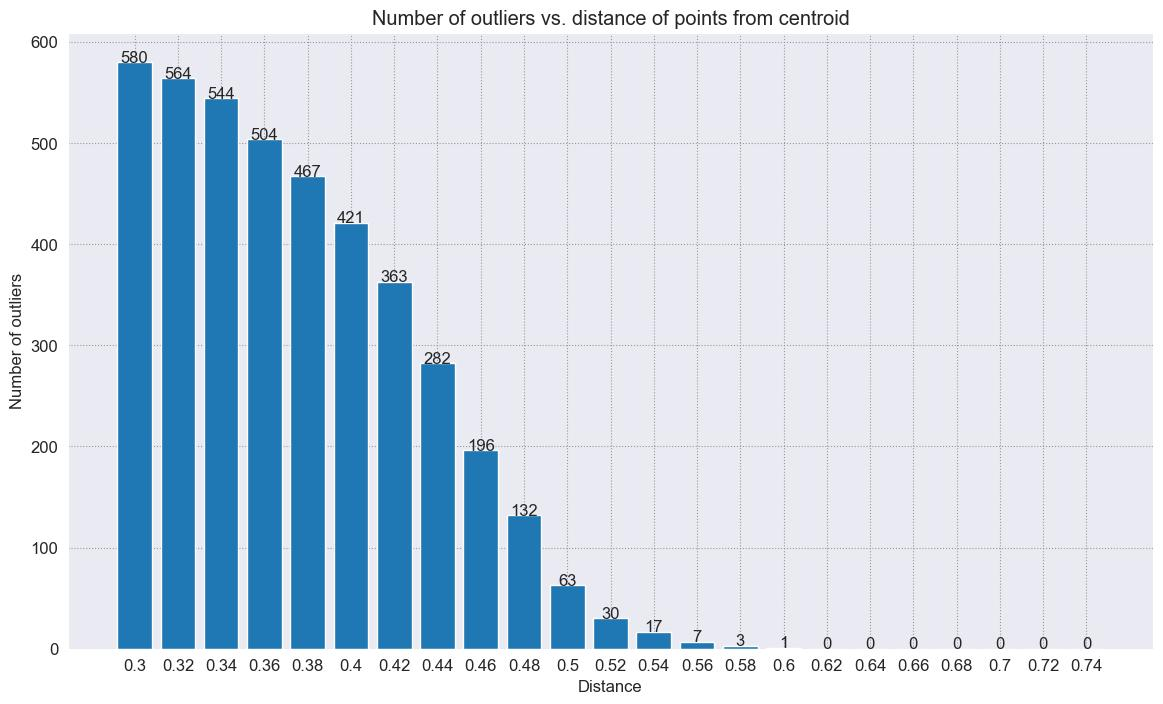

In [83]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.58 is used, but you can change this value.

In [96]:
# View the points that are outliers
RADIUS = 0.54
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
90,Cryptography FAQ 03/10 - Basic Cryptology\nOrg...,11,sci.crypt,"[-0.03167741, -0.00045672545, -0.01068269, -0....",True
97,[Rubick] Shortest Path Algorithm - Status?\nO...,11,sci.crypt,"[-0.022985524, -0.024591176, -0.011402696, -0....",True
147,Re: Trinomial-Based PRNG\nOrganization: Schoo...,11,sci.crypt,"[-0.025036471, -0.005380305, -0.00593743, -0.0...",True
181,"Electric power line ""balls""\nArticle-I.D.: alm...",12,sci.electronics,"[-0.014121288, 0.00074380956, 0.007506555, -0....",True
237,Electrical wiring FAQ (was: A question about 1...,12,sci.electronics,"[-0.0092245415, -0.022044295, 0.0032056107, -0...",True


In [97]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

Text(0, 0.5, 'TSNE2')

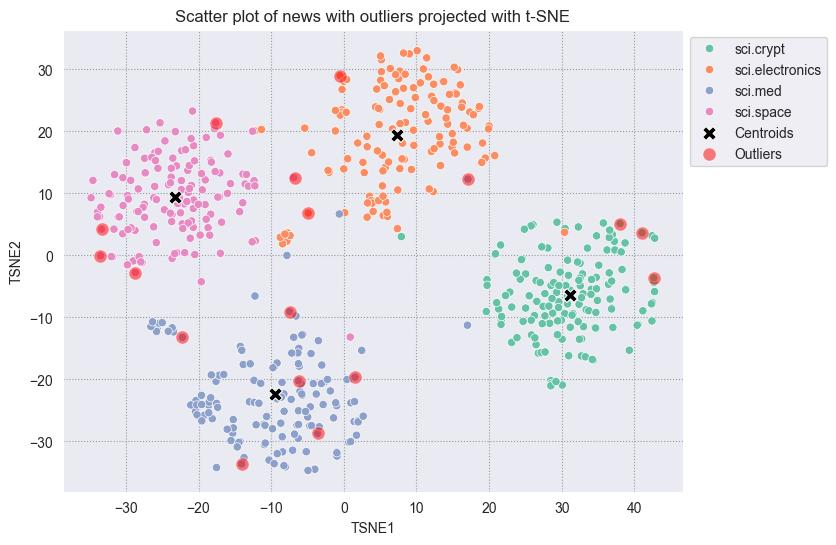

In [98]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [100]:
sci_electronics_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_electronics_outliers['Text'].iloc[0])

Electric power line "balls"
Article-I.D.: almaden.19930406.142616.248
Lines: 4

Power lines and airplanes don't mix. In areas where lines are strung very
high, or where a lot of crop dusting takes place, or where there is danger
of airplanes flying into the lines, they place these plastic balls on the
lines so they are easier to spot.



In [101]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

LARSONIAN Astronomy and Physics
Organization: University of Wisconsin Eau Claire
Lines: 552



                      LARSONIAN Astronomy and Physics

               Orthodox physicists, astronomers, and astrophysicists 
          CLAIM to be looking for a "Unified Field Theory" in which all 
          of the forces of the universe can be explained with a single 
          set of laws or equations.  But they have been systematically 
          IGNORING or SUPPRESSING an excellent one for 30 years! 

               The late Physicist Dewey B. Larson's comprehensive 
          GENERAL UNIFIED Theory of the physical universe, which he 
          calls the "Reciprocal System", is built on two fundamental 
          postulates about the physical and mathematical natures of 
          space and time: 
    
                "The physical universe is composed ENTIRELY of ONE 
          component, MOTION, existing in THREE dimensions, in DISCRETE 
          UNITS, and in two RECIPROCAL forms, SPA

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. 

To learn how to use other services in the Gemini API, see the [Get started](../quickstarts/Get_started.ipynb) guide.